In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf
import tensorflow_io as tfio
import os
from tqdm import tqdm
import cv2
from PIL import Image
from joblib import Parallel, delayed
import gc
from PIL import Image as im
import random

In [2]:
with (open('/kaggle/input/output/training_img_data.pkl', "rb")) as openfile:
     train_data = pickle.load(openfile)

In [3]:
zero_array = np.zeros((128,128))
counter=0
for i,j in enumerate(tqdm(train_data['img_data'])):
    if np.array_equiv(j,zero_array) == True:
        counter+=1
        train_data = train_data.drop(i)
      
print(counter)
        

100%|██████████| 54706/54706 [00:50<00:00, 1077.00it/s]

4969


In [4]:
train_data_pos = train_data[train_data['cancer'] == 1]
train_data_neg = train_data[train_data['cancer'] == 0]

train_data_pos = train_data_pos.sample(frac = 1)
train_data_neg = train_data_neg.sample(frac = 1)

train_data_neg = train_data_neg.sample(frac= 0.35)

frames = 20*[train_data_pos]
frames.append(train_data_neg)
train_data_shuff = pd.concat(frames)
train_data_shuff = train_data_shuff.sample(frac=1)

In [5]:
def random_rotate(imgData):
    imgData = imgData.reshape(128,128)
    imgData = im.fromarray(imgData)
    imgData = np.asarray(imgData.rotate(random.randint(0, 360)))
    return imgData

In [6]:
imgDataList=[]
for j in tqdm(train_data_shuff['img_data']):
    imgDataList.append(random_rotate(j))
train_data_shuff['img_data'] = imgDataList

100%|██████████| 37569/37569 [00:07<00:00, 5074.19it/s]


In [7]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(train_data_shuff, test_size=0.3, random_state=42, shuffle=True)

In [8]:

train_target = np.array(train['cancer'])

In [9]:
train_features=[]
for i in train['img_data']:
    train_features.append([i])
train_features=np.array(train_features)


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_features= []
for i in range(len(train_features)):
    norm_features.append(scaler.fit_transform(train_features[i][0]))
train_features=np.array(norm_features)

In [11]:
train_features = train_features.reshape(len(train_features),128,128,1)



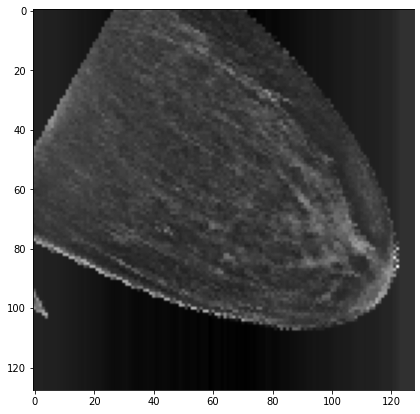

In [12]:
plt.figure(figsize=(7,7))
plt.imshow(train_features[12524],cmap='gray')
#plt.imshow(train_features[50],cmap='gray')


In [13]:
from keras.models import Sequential
from keras.layers import LeakyReLU
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D, Dropout, GlobalMaxPooling2D
model = Sequential()
model.add(Conv2D(16, 5, activation = "relu", input_shape = (128,128,1)))
model.add(MaxPooling2D())
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.2))
model.add(Conv2D(32, 5, activation = "relu"))
model.add(MaxPooling2D())
model.add(LeakyReLU(alpha=0.3))
model.add(Conv2D(64, 3, activation = "relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation = 'relu')) 
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(128, activation = 'relu')) 
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))



2023-01-12 18:29:48.810811: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
model.compile(optimizer = tf.keras.optimizers.Adam(\
    learning_rate=0.001), loss= 'binary_crossentropy', metrics=['accuracy'])



In [15]:
model.fit(train_features, train_target, validation_split=0.3,batch_size = 32,epochs=10)

2023-01-12 18:29:50.402338: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
576/576 [==============================] - 110s 189ms/step - loss: 0.6875 - accuracy: 0.5510 - val_loss: 0.6832 - val_accuracy: 0.5584
Epoch 2/10
576/576 [==============================] - 109s 190ms/step - loss: 0.6807 - accuracy: 0.5620 - val_loss: 0.6774 - val_accuracy: 0.5599
Epoch 3/10
576/576 [==============================] - 108s 188ms/step - loss: 0.6736 - accuracy: 0.5721 - val_loss: 0.6749 - val_accuracy: 0.5596
Epoch 4/10
576/576 [==============================] - 109s 190ms/step - loss: 0.6651 - accuracy: 0.5843 - val_loss: 0.6995 - val_accuracy: 0.5665
Epoch 5/10
576/576 [==============================] - 109s 189ms/step - loss: 0.6477 - accuracy: 0.6089 - val_loss: 0.6796 - val_accuracy: 0.5719
Epoch 6/10
576/576 [==============================] - 109s 188ms/step - loss: 0.6194 - accuracy: 0.6423 - val_loss: 0.6844 - val_accuracy: 0.5783
Epoch 7/10
576/576 [==============================] - 109s 190ms/step - loss: 0.5734 - accuracy: 0.6910 - val_loss: 0.7260 -

In [16]:
test_features=[]
for i in test['img_data']:
    test_features.append([i])
test_features=np.array(test_features)




scaler = StandardScaler()
norm_features= []
for i in range(len(test_features)):
    norm_features.append(scaler.fit_transform(test_features[i][0]))
test_features=np.array(norm_features)




test_features = test_features.reshape(len(test_features),128,128,1)






test_target = np.array(test['cancer'])

In [17]:
pred = model.predict(test_features)
bin_pred = []
for i in pred:
    if i>=0.5:
        bin_pred.append(1)
    else:
        bin_pred.append(0)
bin_pred = np.array(bin_pred)
print(bin_pred)

[1 1 1 ... 0 0 1]


In [18]:
import sklearn
acc = sklearn.metrics.accuracy_score(test_target, bin_pred)
print(acc)

0.6041167598261024


In [19]:
countzero=0
countone=0
countzerot=0
countonet=0
for i, j in zip(test_target, bin_pred):
    if i==0 and j==0:
        countzero+=1
    if i==1 and j==1:
        countone+=1
    if i==1:
        countonet+=1
    if i==0:
        countzerot+=1
print(countzero/countzerot,countone/countonet)

0.49479473580828914 0.6941747572815534
